In [1]:
%matplotlib inline

In [2]:
from matplotlib.pylab import *

In [3]:
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")
rc('figure', figsize=(8, 4))
rc('savefig', bbox='tight')
plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [4]:
param_grid = {
              'mo': [0.0, 0.5, 0.9],  # momentum
              'width': [4, 6, 8],  # network width
              'wd': [0.0, 1e-4, 5e-4],  # weight decay
              'lr': [0.01, 0.0075, 0.005],  # learning rate
              'bs': [32, 128, 512],  # batch size
              'skip': [True, False], # skip
              'batchnorm': [True, False]  # batchnorm
}
labels = ["$\epsilon$ sharp", "PAC", "$Frobenius", "FRN", "Shannon", "Local","Trace", "Low pass filter"]
all_measures = ["eps_flat", "pac_bayes", "fro_norm", "fim", "shannon_entropy","local_entropy_grad_norm", "eig_trace", "low_pass"]

In [ ]:
# check problematic models
inp = []
for folder in glob.glob("checkpoints/cifar10/resnet/*_0_*"):
    try:
        name = glob.glob(f"{folder}/run_ms_0/measures.pkl")[0]
        with open(name, 'rb') as f:
            measures = pickle.load(f)
        print(measures['train_loss'])
        if measures['train_loss'] > 0.01 or any(np.isnan(list(measures.values()))):
            print(measures)
    except:
        print(folder)  

$\epsilon$ sharp & 0.383
PAC & 0.466
Frobenius & 0.481
FRN & 0.270
Shannon & 0.296
$\mu_{LE}$ & -0.064
LPF based measure & 0.606


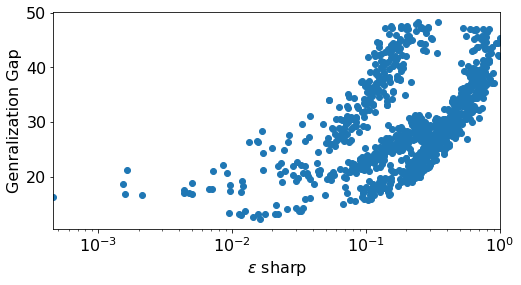

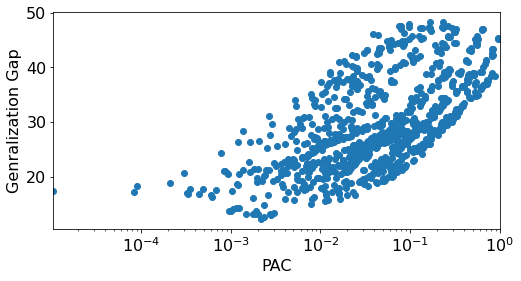

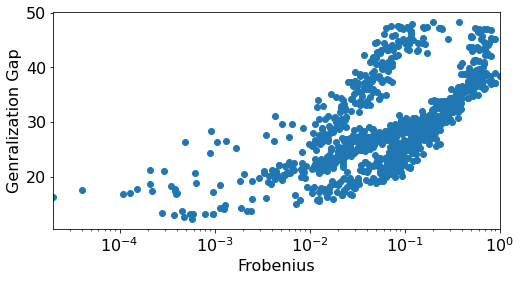

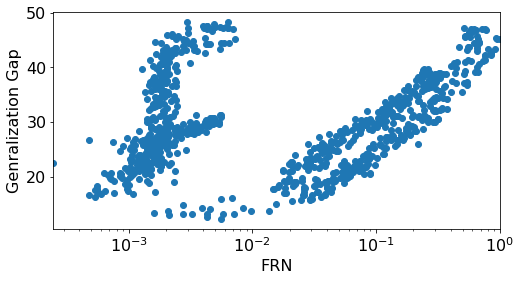

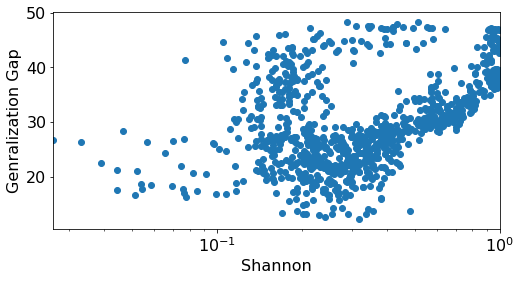

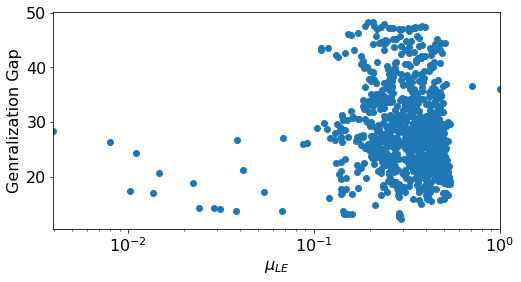

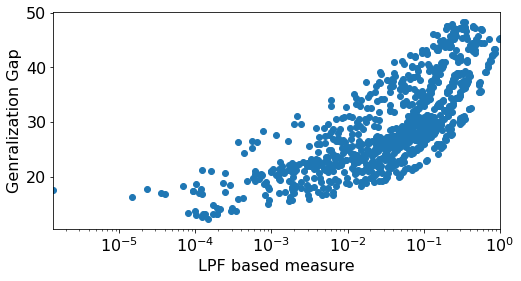

In [5]:
#############################################################
#                           SCATTER PLOTS
###########################################################
import os

labels = ["$\epsilon$ sharp", "PAC", "Frobenius", "FRN", "Shannon", "$\mu_{LE}$", "LPF based measure"]
all_measures = ["eps_flat", "pac_bayes", "fro_norm", "fim", "shannon_entropy","local_entropy_grad_norm", "low_pass"]

for meas_idx, meas in enumerate(all_measures):
    plotting_needs = [[], []]
   
    for fol in glob.glob1(f"checkpoints/cifar10/resnet/",f"*_0_*"):
        meas_mean = []
        gap_mean = []
        for ms in [0,1,2]:
            fol = fol.split("_")[0]+f"_{ms}_"+ "_".join(fol.split('_')[2:])
            
            if os.path.isfile(f"checkpoints/cifar10/resnet/{fol}/run_ms_{ms}/measures.pkl"):
                with open(f"checkpoints/cifar10/resnet/{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)            

                if measures["train_loss"] > 0.01:
                    continue

                if meas in measures and not np.isnan(measures[meas]):
#                     if meas == "local_entropy_grad_norm":
#                         continue
                    meas_mean.append(measures[meas])
                    gap_mean.append(-measures["val_acc"]+measures["train_acc"])
        if len(meas_mean) == 3:
            plotting_needs[0].append(np.mean(meas_mean))
            plotting_needs[1].append(np.mean(gap_mean))
        
    plotting_needs[0] = np.array(plotting_needs[0])
    plotting_needs[0] -= np.min(plotting_needs[0])
    plotting_needs[0] /= np.max(plotting_needs[0])
    
    fig, ax = plt.subplots()
    ax.scatter(plotting_needs[0], plotting_needs[1])
    ax.set_ylabel("Genralization Gap",fontsize=16)
    ax.set_xlabel(f"{labels[meas_idx]}",fontsize=16)
#     ax.set_title(f"{labels[meas_idx]}",fontsize=16)
    ax.set_xlim([np.sort(plotting_needs[0])[1],1])
    ax.set_xscale('log')
#     ax.legend([f"{labels[meas_idx]}: {scipy.stats.kendalltau(plotting_needs[0], plotting_needs[1])[0]:0.3f}"])
    plt.savefig(f"results/nips/scatter_{labels[meas_idx]}.eps", transparent=False, bbox_inches='tight')
    print(f"{labels[meas_idx]} & {scipy.stats.kendalltau(plotting_needs[0], plotting_needs[1])[0]:0.3f}")

# additional results
# plotting_needs = [[], []]

# for fol in glob.glob1(f"checkpoints/cifar10 copy/resnet/",f"*_0_*"):
#     meas_mean = []
#     gap_mean = []

#     if os.path.isfile(f"checkpoints/cifar10 copy/resnet/{fol}/run_ms_0/measures.pkl"):
#         with open(f"checkpoints/cifar10 copy/resnet/{fol}/run_ms_0/measures.pkl", 'rb') as f:
#             measures = pickle.load(f)            

#         if measures["train_loss"] > 0.01:
#             continue

#         eig_val = np.load(f"checkpoints/cifar10/resnet/{fol}/run_ms_0/eig_val.npy")
#         if any(np.isnan(eig_val)):
#             print(fol)
#             continue

#         meas_mean.append(np.sum(eig_val / (eig_val + 1))) # just change this to eig-max and d_eff
#         gap_mean.append(-measures["val_acc"]+measures["train_acc"])

#     if len(meas_mean) == 1:
#         plotting_needs[0].append(np.mean(meas_mean))
#         plotting_needs[1].append(np.mean(gap_mean))

# plotting_needs[0] = np.array(plotting_needs[0])
# plotting_needs[0] -= np.min(plotting_needs[0])
# plotting_needs[0] /= np.max(plotting_needs[0])

# fig, ax = plt.subplots()
# ax.scatter(plotting_needs[0], plotting_needs[1])
# ax.set_ylabel("Genralization Gap",fontsize=16)
# ax.set_xlabel("$\mu_{eigmax}$",fontsize=16)
# # ax.set_title(f"{labels[meas_idx]}",fontsize=16)
# ax.set_xlim([np.sort(plotting_needs[0])[1],1])
# ax.set_xscale('log')

# print(f"{scipy.stats.kendalltau(plotting_needs[0], plotting_needs[1])[0]:0.3f}")


In [ ]:
############################################################## 
#                     same results as my nips papers
#############################################################
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
# pick a measure
for meas in all_measures:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():

        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        # loop over all other set of hyper-parameters
        for params in grid:
            flat_measure_mean = []
            gen_gap_mean = []
            # and just vary a single hyper-parameter that we picked
            for v in value:
                params[key] = v
                flat_measure = []
                gen_gap = []
                for ms in [0,1,2]:
                    # cifar
                    name = f"checkpoints/cifar10 copy/resnet/" \
                           f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                           f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                    fol = glob.glob(name)[0]

                    try:
                        with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                            measures = pickle.load(f)
                    except:
                        continue
                    # discard model with less cross-entropy               
                    if measures["train_loss"] > 0.01:
                        continue

                    # record flatness and gen_gap for it
                    try:
                        flat_measure.append(measures[meas])
                    except:
                        continue

                    gen_gap.append(-measures["val_acc"] + measures["train_acc"])

                if len(flat_measure) > 0:
                    flat_measure_mean.append(np.mean(flat_measure))
                    gen_gap_mean.append(np.mean(gen_gap))

            # compute tau and append (this is inner tau in equation 4 of fantastic)
            # just that our tau is not kendall but pearson
            if len(gen_gap_mean) > 1:
                if not any(np.isnan(flat_measure_mean)):
                    c = scipy.stats.kendalltau(flat_measure_mean, gen_gap_mean)[0]
                    corr.append(c)
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(corr):0.3f} & ", end='')
    idx+=1
    print('')

In [ ]:
import os

# additional results based on sharpness
# pick a hyper-parameter
for key, value in param_grid.items():

    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        flat_measure_mean = []
        gen_gap_mean = []
        
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[key] = v
            flat_measure = []
            gen_gap = []
            for ms in [0]:
                # cifar
                name = f"checkpoints/cifar10/resnet/" \
                       f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                       f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]
                try:
                    with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                        measures = pickle.load(f)
                except:
                    continue
                        
                if os.path.isfile(f"{fol}/run_ms_{ms}/eig_val.npy"):
                    eig_val = np.load(f"{fol}/run_ms_{ms}/eig_val.npy")
                else:
                    continue
                
                # discard model with less cross-entropy               
                if measures["train_loss"] > 0.01:
                    continue

                # record flatness and gen_gap for it
                try:
                    flat_measure.append(np.sum(eig_val / (eig_val + 1)))
                except:
                    continue

                gen_gap.append(-measures["val_acc"] + measures["train_acc"])

            if len(flat_measure) > 0:
                flat_measure_mean.append(np.mean(flat_measure))
                gen_gap_mean.append(np.mean(gen_gap))

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        if len(gen_gap_mean) > 1:
            if not any(np.isnan(flat_measure_mean)):
                c = scipy.stats.kendalltau(flat_measure_mean, gen_gap_mean)[0]
                corr.append(c)
    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.3f} & ", end='')

In [ ]:
############################################################## 
#                     same results as my nips papers (sharp vs params)
#############################################################
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
# pick a measure
for meas in all_measures:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():

        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        # loop over all other set of hyper-parameters
        for params in grid:
            flat_measure_mean = []
            parameter_mean = []
            # and just vary a single hyper-parameter that we picked
            for v in value:
                params[key] = v
                flat_measure = []
                parameter = []
                for ms in [0,1,2]:
                    # cifar
                    name = f"checkpoints/cifar10 copy/resnet/" \
                           f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                           f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                    fol = glob.glob(name)[0]

                    try:
                        with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                            measures = pickle.load(f)
                    except:
                        continue
                    # discard model with less cross-entropy               
                    if measures["train_loss"] > 0.01:
                        continue

                    # record flatness and gen_gap for it
                    try:
                        flat_measure.append(measures[meas])
                    except:
                        continue

                    if v== True:
                        parameter.append(1)
                    elif v == False:
                        parameter.append(0)
                    else:
                        parameter.append(v)

                if len(flat_measure) > 0:
                    flat_measure_mean.append(np.mean(flat_measure))
                    parameter_mean.append(np.mean(parameter))

            # compute tau and append (this is inner tau in equation 4 of fantastic)
            # just that our tau is not kendall but pearson
            if len(parameter_mean) > 1:
                if not any(np.isnan(flat_measure_mean)):
                    c = scipy.stats.kendalltau(flat_measure_mean, parameter_mean)[0]
                    corr.append(c)
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(corr):0.3f} & ", end='')
    idx+=1
    print('')

In [ ]:
import os

# additional results based on sharpness
# pick a hyper-parameter
for key, value in param_grid.items():

    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        flat_measure_mean = []
        parameter_mean = []
        
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[key] = v
            flat_measure = []
            parameter = []
            for ms in [0]:
                # cifar
                name = f"checkpoints/cifar10/resnet/" \
                       f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                       f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]
                try:
                    with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                        measures = pickle.load(f)
                except:
                    continue
                        
                if os.path.isfile(f"{fol}/run_ms_{ms}/eig_val.npy"):
                    eig_val = np.load(f"{fol}/run_ms_{ms}/eig_val.npy")
                else:
                    continue
                
                # discard model with less cross-entropy               
                if measures["train_loss"] > 0.01:
                    continue

                # record flatness and gen_gap for it
                try:
                    flat_measure.append(np.sum(eig_val / (eig_val + 1)))
                except:
                    continue

                if v== True:
                    parameter.append(1)
                elif v == False:
                    parameter.append(0)
                else:
                    parameter.append(v)
                        
            if len(flat_measure) > 0:
                flat_measure_mean.append(np.mean(flat_measure))
                parameter_mean.append(np.mean(parameter))

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        if len(parameter_mean) > 1:
            if not any(np.isnan(flat_measure_mean)):
                c = scipy.stats.kendalltau(flat_measure_mean, parameter_mean)[0]
                corr.append(c)
    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.3f} & ", end='')

In [ ]:
print("Empirical order & ", end=' ')
for key, value in param_grid.items():
    print(f"{key} &", end=' ')
print(' ')

for key, value in param_grid.items():

    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        gen_gap = []
        hyp = []
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[f"{key}"] = v
            # cifar
            name = f"checkpoints/cifar10/resnet/" \
                   f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                   f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

            fol = glob.glob(name)[0]

            try:
                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)
            except:
                continue

            if measures["train_loss"] > 0.01:
                continue
            else:
                # record flatness and hyper-parameter for it
                gen_gap.append((100 - measures["val_acc"]))
                if v is True:
                    hyp.append(1)
                elif v is False:
                    hyp.append(0)
                else:
                    hyp.append(v)

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        if len(gen_gap) > 1:
            c = scipy.stats.kendalltau(hyp, gen_gap)[0]
            if not math.isnan(c):
                corr.append(c)
    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.4f} & ", end='')

In [ ]:
for x in param_grid.keys():
    print(x, end=', ')
print('')

all_measures = ["low_pass"]
labels = ["Low Pass"]

idx = 0
for meas in all_measures:
    print(f"{meas} & ", end='')
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        for params in grid:
            flat_measure = []
            hyper_param = []
            for v in value:
                params[f"{key}"] = v
            
                # cifar
                name = f"checkpoints/cifar10/resnet/" \
                       f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                       f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]

                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)
                
                if measures['train_loss'] > 0.01 or any(np.isnan(list(measures.values()))):
                    continue
                else:
                    flat_measure.append(measures[meas])
                    if v is True:
                        hyper_param.append(1)
                    elif v is False:
                        hyper_param.append(0)
                    else:
                        hyper_param.append(v)

            if len(hyper_param)>1:
                flat_measure = [x / np.max(flat_measure) for x in flat_measure]
                corr.append(scipy.stats.spearmanr(hyper_param, flat_measure)[0])

        print(f"{np.mean(corr):0.3f} & ", end='')
    print('')

In [ ]:
#scatter plots for anna
all_measures = ["low_pass3"]
labels = ["Normalized Low Pass $\sigma=0.001$"]

idx = 0
# pick a measure
for meas_idx, meas in enumerate(all_measures):
    fig,ax = plt.subplots()
    for idx, width in enumerate([4, 6, 8]):
        plotting_needs = [[], []]
        for params in list(ParameterGrid(param_grid)):
            name = f"checkpoints/cifar10/resnet/" \
                   f"*_0_{params['mo']}_{width}_{params['wd']}_" \
                   f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

            fol = glob.glob(name)[0]
            try:
                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)            
                if measures["train_loss"] > 0.01:
                    continue
                if not np.isnan(measures[meas]):
                    plotting_needs[0] += [measures[meas]]
                else:
                    continue
            except:
                continue
            plotting_needs[1] += [-measures["val_acc"]+measures["train_acc"]]
        ax.scatter([x / np.max(plotting_needs[0]) for x in plotting_needs[0]], plotting_needs[1], label = f"Width={width}")
    ax.set_ylabel("Genralization Gap",fontsize=16)
    ax.set_xlabel(f"{labels[meas_idx]}",fontsize=16)
    ax.set_xlim([0, 0.01])
#     ax.set_xscale('log')
    ax.legend(fontsize=16)
    fig.savefig(f"results/scatter/{all_measures[meas_idx]}_reg_zoom2.png")
#     plt.close()

In [ ]:
####################### APPENDIX ###################################
# average the results over seed
# same results as fantastic papers
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')

idx = 0
# pick a measure
for meas in all_measures:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():

        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        mean_corr = []
        for ms in [2]:
            corr = []
            # loop over all other set of hyper-parameters
            for params in grid:
                flat_measure = []
                gen_gap = []
                # and just vary a single hyper-parameter that we picked
                for v in value:
                    params[key] = v
                    # cifar
                    name = f"checkpoints/cifar10/resnet/" \
                           f"*_{ms}_{params['mo']}_{params['width']}_{params['wd']}_" \
                           f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"
                    fol = glob.glob(name)[0]
                    try:
                        with open(f"{fol}/run_ms_{ms}/measures.pkl", 'rb') as f:
                            measures = pickle.load(f)
                    except:
                        continue
                    # discard model with less cross-entropy               
                    if measures["train_loss"] > 0.01:
                        continue
                    # record flatness and gen_gap for it
                    try:
                        flat_measure.append(measures[meas])
                    except:
                        continue
                    gen_gap.append(-measures["val_acc"]+measures["train_acc"])

                # compute tau and append (this is inner tau in equation 4 of fantastic)
                if len(gen_gap) > 1:
                    c = scipy.stats.kendalltau(flat_measure, gen_gap)[0]
                    if not math.isnan(c):
                        corr.append(c)
            mean_corr.append(np.mean(corr))
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(mean_corr):0.4f} & ", end='')
    idx+=1
    print(' ')